<a href="https://colab.research.google.com/github/mnjkhtri/brain-tumor-detection-and-localization/blob/main/brain_tumor_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import pandas as pd
import numpy as np
import glob
import os
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


In [28]:
DATA_PATH = "/content/drive/MyDrive/ColabNotebooks/kaggle_3m/"

In [29]:
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)


df = pd.DataFrame(
    {"dirname" : data_map[::2], "path" : data_map[1::2]}
)

df.head()

This is not a dir: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/README.md
This is not a dir: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/data.csv


,dirname,path
0,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...
1,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...
2,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...
3,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...
4,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...


In [56]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = len(df_imgs['path'].values[0]) - len('xx.tif')
END_IMG_LEN = -len('.tif')
END_MASK_LEN = -len('xmask.tif')

In [57]:
df_imgs['path'].values[0][BASE_LEN:END_IMG_LEN], df_masks['path'].values[0][BASE_LEN:END_MASK_LEN]

('14', '16')

In [62]:
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:END_MASK_LEN]))

In [63]:
# Sorting check
idx = np.random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_19.tif 
Path to the Mask: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_19_mask.tif


In [67]:
df = pd.DataFrame(
    {"patient": df_imgs.dirname.values, "image_path": imgs, "mask_path": masks}
)

def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))

In [68]:
df['diagnosis'].sum()

1373

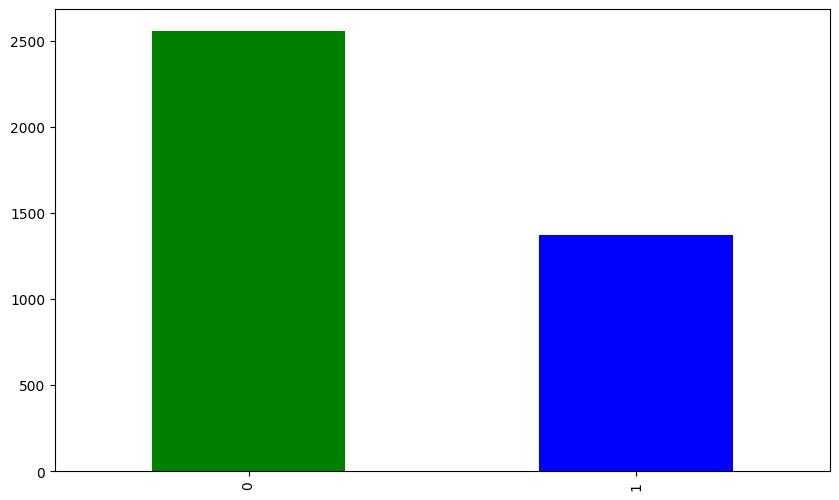

In [69]:
ax = df.diagnosis.value_counts().plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=["green", "blue"]
)

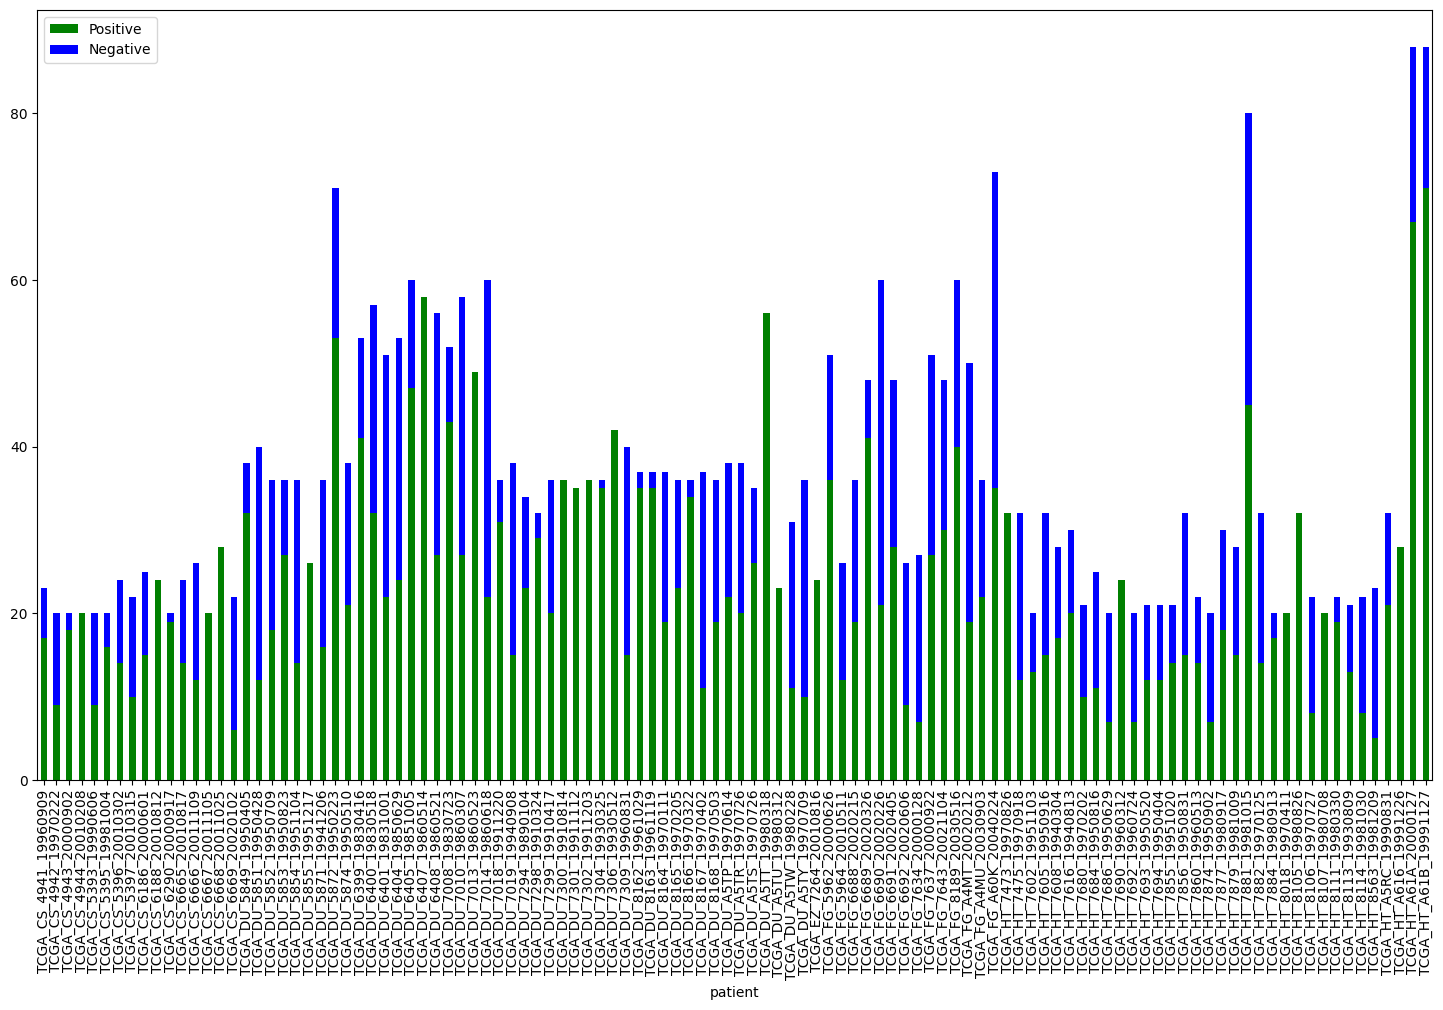

In [70]:
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

ax = patients_by_diagnosis.plot(
    kind='bar',
    stacked=True,
    figsize=(18, 10),
    color=["green", "blue"],
)

In [73]:
IMG_SIZE = 512

sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])

In [82]:
sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

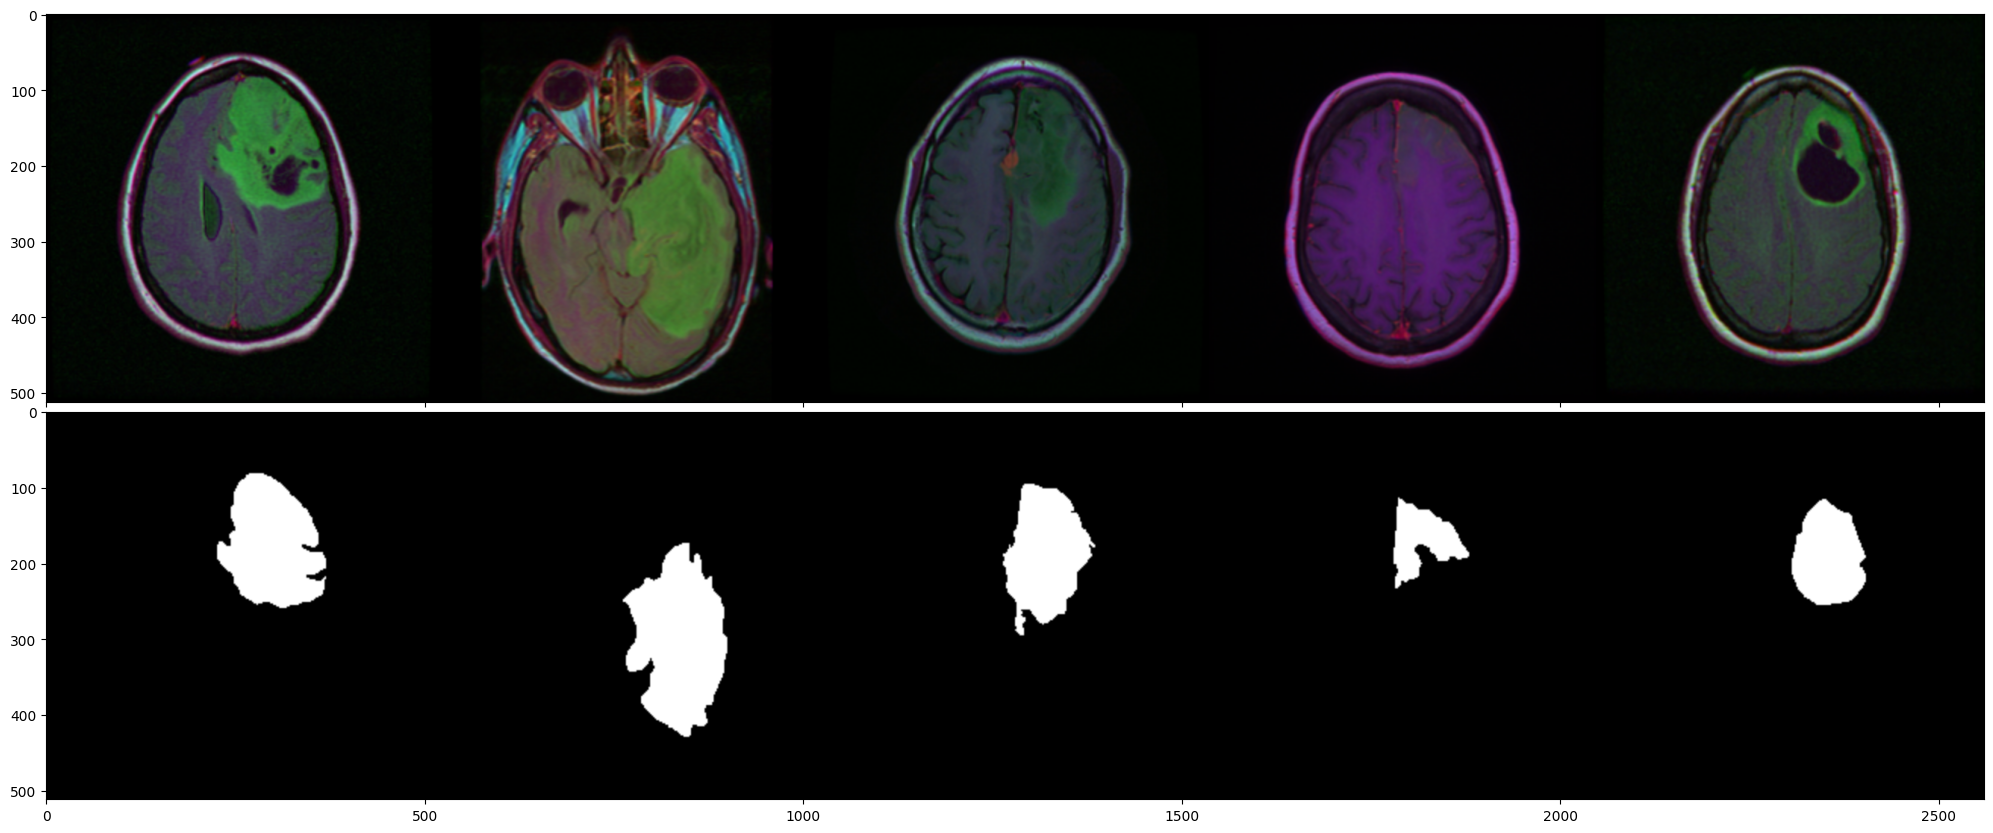

In [81]:
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.1)

grid[0].imshow(sample_imgs_arr)
grid[1].imshow(sample_masks_arr)